# Test isotherm fitting

Our strategy here is to generate data points that follow a given isotherm model, then fit an isotherm model to the data using pyIAST, and check that pyIAST identifies the parameters correctly.

In [1]:
import pyiast
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

We test all analytical models implemented in pyIAST.

In [2]:
models = pyiast._MODELS
models

['Langmuir',
 'Quadratic',
 'BET',
 'Sips',
 'DSLF',
 'Henry',
 'Freundlich',
 'TemkinApprox']

This dictionary gives the model parameters for which we generate synthetic data to test pyIAST fitting. Note that, because the DSLF model has so many parameters, it is highly likely that such a model will overfit the data. Thus, we expect pyIAST to reach a local minimum for DSLF yet still obtain a reasonable fit with the default starting guess.

In [3]:
model_params = {
    "Langmuir": {"M": 10.0, "K": 10.0},
    "Quadratic": {"M": 10.0, "Ka": 10.0, "Kb": 10.0 ** 2 * 3},
    "BET": {"M": 10.0, "Ka": 10.0, "Kb": .2},
    "Sips": {"M": 10.0, "K": 10.0, "n": 0.5},
    "DSLF": {"M1": 30.0, "K1": 30.0, "n1": 1.0,
             "M2": 20.0, "K2": 1.0, "n2":1.0},
    "Henry": {"KH": 10.0},
    "Freundlich": {"K": 10.0, "a": 2.0},
    "TemkinApprox": {"M": 10.0, "K": 10.0, "theta": -0.1}
}

The loading function generates synthetic data for a given model. We pass it an array of pressures and it returns loading using the given model. Note that the parameters for each model are taken from the above dictionary.

In [4]:
def loading(P, model):
    """
    Return loading at pressure P using a given model.
    
    :param P: np.array array of pressures
    :param model: string specify model
    """
    if model not in models:
        raise Exception("This model is not implemented in the test suite.")
        
    if model == "Langmuir":
        M = model_params[model]["M"] 
        K = model_params[model]["K"] 
        return M * K * P / (1.0 + K * P)
    
    if model == "Quadratic":
        M = model_params[model]["M"] 
        Ka = model_params[model]["Ka"] 
        Kb = model_params[model]["Kb"] 
        return M * P * (Ka + 2.0 * Kb * P) / (1.0 + Ka * P + Kb * P ** 2)
    
    if model == "BET":
        M = model_params[model]["M"] 
        Ka = model_params[model]["Ka"] 
        Kb = model_params[model]["Kb"]
        return M * Ka * P / (1.0 - Kb * P) / (1.0 - Kb * P + Ka * P)
    
    if model == "Sips":
        M = model_params[model]["M"] 
        K = model_params[model]["K"]
        n = model_params[model]["n"]
        return M * (K * P) ** n / (1.0 + (K * P) ** n)
    
    if model == "DSLF":
        M1 = model_params[model]["M1"] 
        K1 = model_params[model]["K1"]
        n1 = model_params[model]["n1"]
        M2 = model_params[model]["M2"] 
        K2 = model_params[model]["K2"]
        n2 = model_params[model]["n2"]
        return M1 * (K1 * P) ** n1 / (1.0 + (K1 * P) ** n1) +\
               M2 * (K2 * P) ** n2 / (1.0 + (K2 * P) ** n2)
    
    if model == "TemkinApprox":
        M = model_params[model]["M"]
        K = model_params[model]["K"]
        theta = model_params[model]["theta"]
        
        fractional_langmuir_loading = K * P / (1.0 + K * P)
        return M * (fractional_langmuir_loading + theta *
                    fractional_langmuir_loading ** 2 * 
                    fractional_langmuir_loading)
 
    if model == "Henry":
        return model_params[model]["KH"] * P
    
    if model == "Freundlich":
        return model_params[model]["K"] * P ** model_params[model]["a"]

## Test model fits

Loop through all models, generate synthetic data using parameters in `model_params` and the `loading` function here, then fit model using pyIAST. Plot data and fits, check that pyIAST identified parameters match the model.

Testing model: Langmuir
Langmuir identified model parameters:
	K = 9.999948
	M = 10.000008
RMSE =  4.18584472013e-06


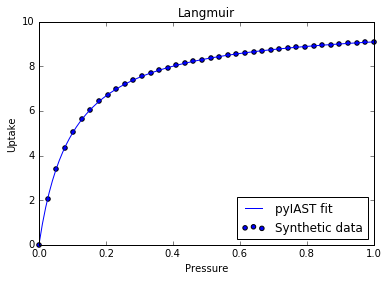

Testing model: Quadratic
Quadratic identified model parameters:
	Kb = 299.999978
	Ka = 10.000002
	M = 10.000000
RMSE =  1.2329463415e-07


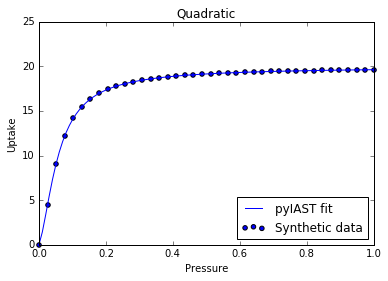

Testing model: BET
BET identified model parameters:
	Kb = 0.200001
	Ka = 10.000081
	M = 9.999978
RMSE =  4.22173425402e-06


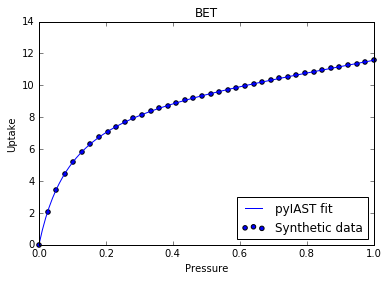

Testing model: Sips
Sips identified model parameters:
	K = 9.999969
	M = 10.000008
	n = 0.499999
RMSE =  3.44924793236e-07


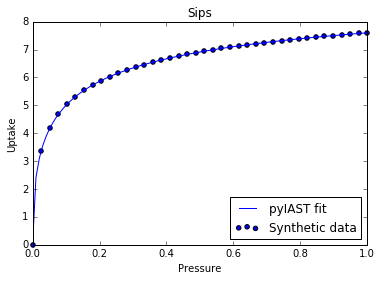

Testing model: DSLF
DSLF identified model parameters:
	K2 = 20.502228
	K1 = 5.472604
	M1 = 51.186313
	M2 = 2.726724
	n1 = 0.519620
	n2 = 10.299733
RMSE =  0.0774384878983


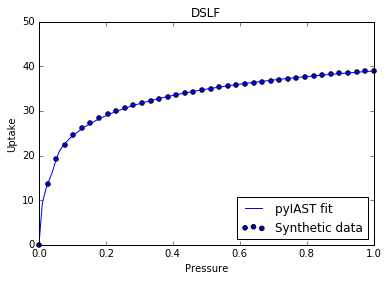

The DSLF model has many parameters and thus will likely overfit 
        the data. As such, the optimization routine in SciPy, used by pyIAST, reaches 
        a local minimum and does not discover the true parameters in the model. This is
        expected when a model is overfit to the data. For this reason, I suggest to 
        not use DSLF. For testing the implementation of DSLF in pyIAST, visually inspect
        the fit.
Testing model: Henry
Henry identified model parameters:
	KH = 9.999995
RMSE =  3.14865810189e-06


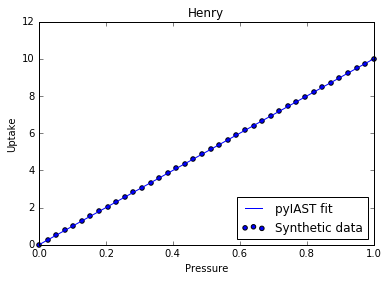

Testing model: Freundlich
Freundlich identified model parameters:
	a = 1.999979
	K = 9.999931
RMSE =  2.33558220446e-05


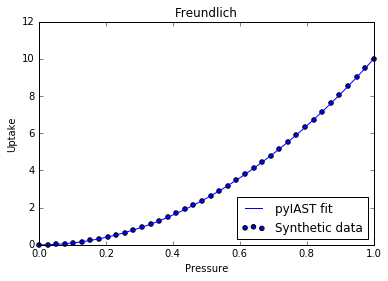

Testing model: TemkinApprox
TemkinApprox identified model parameters:
	theta = -0.099999
	K = 10.000009
	M = 9.999992
RMSE =  6.70905656837e-07


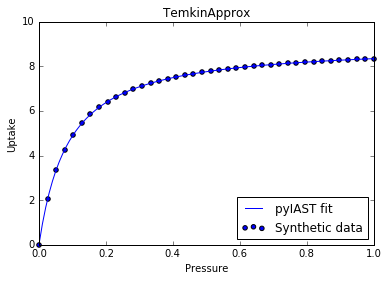

In [5]:
for model in models:
    print "Testing model:", model
    
    # Generate synthetic data
    df = pd.DataFrame()
    df['P'] = np.linspace(0, 1, 40)
    df['L'] = loading(df['P'], model)
    
    # use pyIAST to fit model to data
    isotherm = pyiast.ModelIsotherm(df, pressure_key='P', loading_key='L', 
                                    model=model)
    isotherm.print_params()
    
    # plot fit
    P_plot = np.linspace(0, 1, 100)

    fig = plt.figure()
    plt.scatter(df['P'], df['L'], label='Synthetic data', clip_on=False)
    plt.plot(P_plot, isotherm.loading(P_plot), label='pyIAST fit')
    plt.xlim([0, 1])
    plt.ylim(ymin=0)
    plt.xlabel('Pressure')
    plt.ylabel('Uptake')
    plt.title(model)
    plt.legend(loc='lower right')
    plt.show()
    
    # assert parameters are equal
    if model != "DSLF":
        for param in isotherm.params.keys():
            np.testing.assert_almost_equal(isotherm.params[param], model_params[model][param],
                                decimal=3)
    else:
        print """The DSLF model has many parameters and thus will likely overfit 
        the data. As such, the optimization routine in SciPy, used by pyIAST, reaches 
        a local minimum and does not discover the true parameters in the model. This is
        expected when a model is overfit to the data. For this reason, I suggest to 
        not use DSLF. For testing the implementation of DSLF in pyIAST, visually inspect
        the fit."""

### Quick visual test on the Interpolator isotherm

/usr/local/lib/python2.7/dist-packages/pyiast-1.0-py2.7.egg/isotherms.py:426: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  self.df = df.sort([pressure_key], ascending=True)


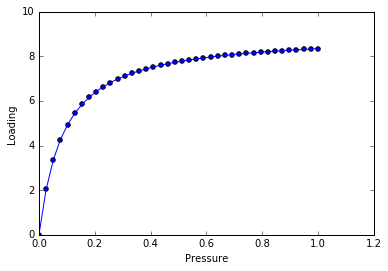

In [6]:
isotherm = pyiast.InterpolatorIsotherm(df, pressure_key='P', loading_key='L')
pyiast.plot_isotherm(isotherm)